# Assignment 2 | Image Classification, December 2021

- [Artificial Neural Networks and Deep Learning 2021 - Homework 2](https://codalab.lisn.upsaclay.fr/competitions/621)

## Three convolutioneers

- *Aleksandra Krajnovic*
- *Iva Milojkovic*
- *Mariusz Wiśniewski*

### Import libraries

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

plt.rc('font', size=16)
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Utility function to create folders and callbacks for training

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    return callbacks

### Exploration Data Analysis (EDA)


### Load the dataset

In [4]:
dataset = pd.read_csv('/kaggle/input/multivariatetimeseries/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


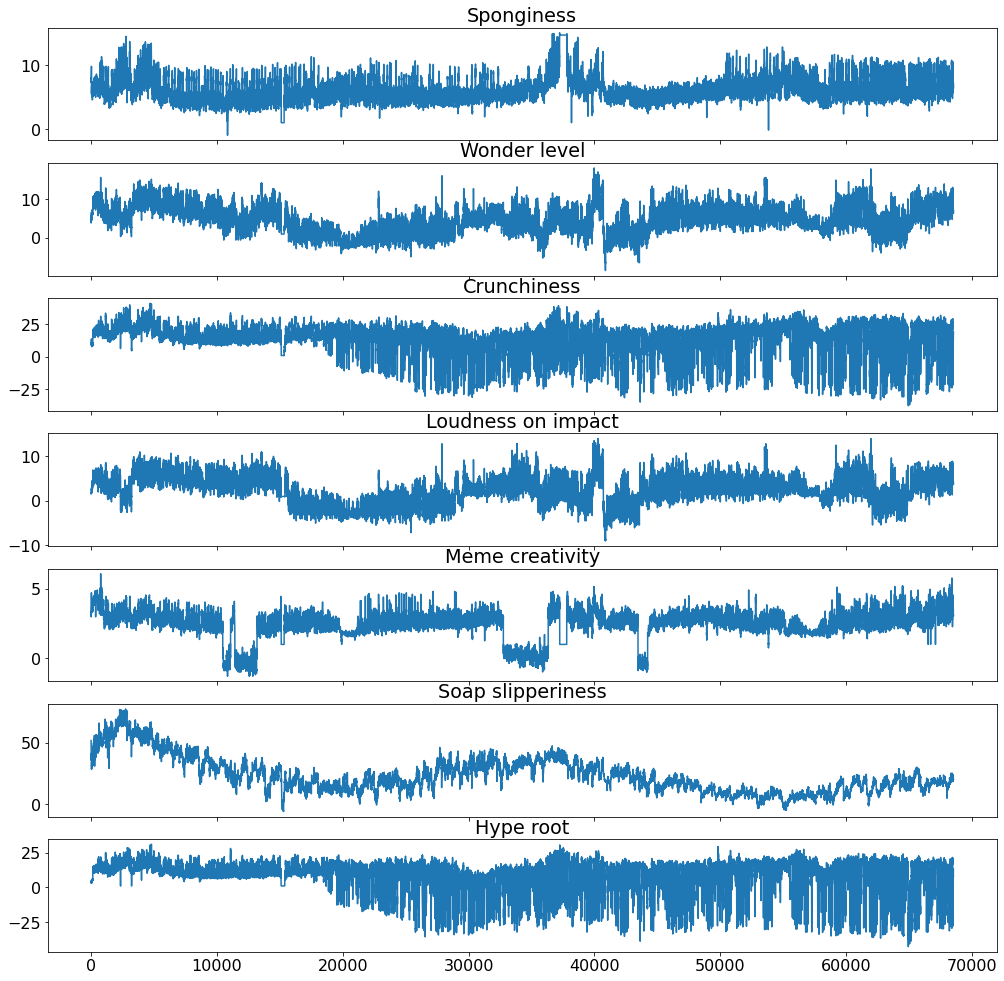

In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()


inspect_dataframe(dataset, dataset.columns)

### Normalization

(68528, 7)
       Sponginess  Wonder level  Crunchiness  Loudness on impact  \
0         7.97698       4.33494    10.672820             1.76692   
1         8.07824       4.44616    10.561600             1.70716   
2         8.02844       4.22372    10.561600             1.64906   
3         8.02844       4.22372    10.561600             1.70716   
4         7.87572       4.44616    10.450380             1.70716   
...           ...           ...          ...                 ...   
68523     6.30868       6.33690    15.342401             4.24364   
68524     6.40994       6.55934    16.343380             3.77220   
68525     6.76352       7.00422    17.233140             3.94982   
68526     6.86478       6.67056    17.900460             3.94982   
68527     7.16856       7.11544    19.235099             4.12578   

       Meme creativity  Soap slipperiness  Hype root  
0              3.22440          51.681460    3.65434  
1              3.32566          51.563598    3.47672  
2      

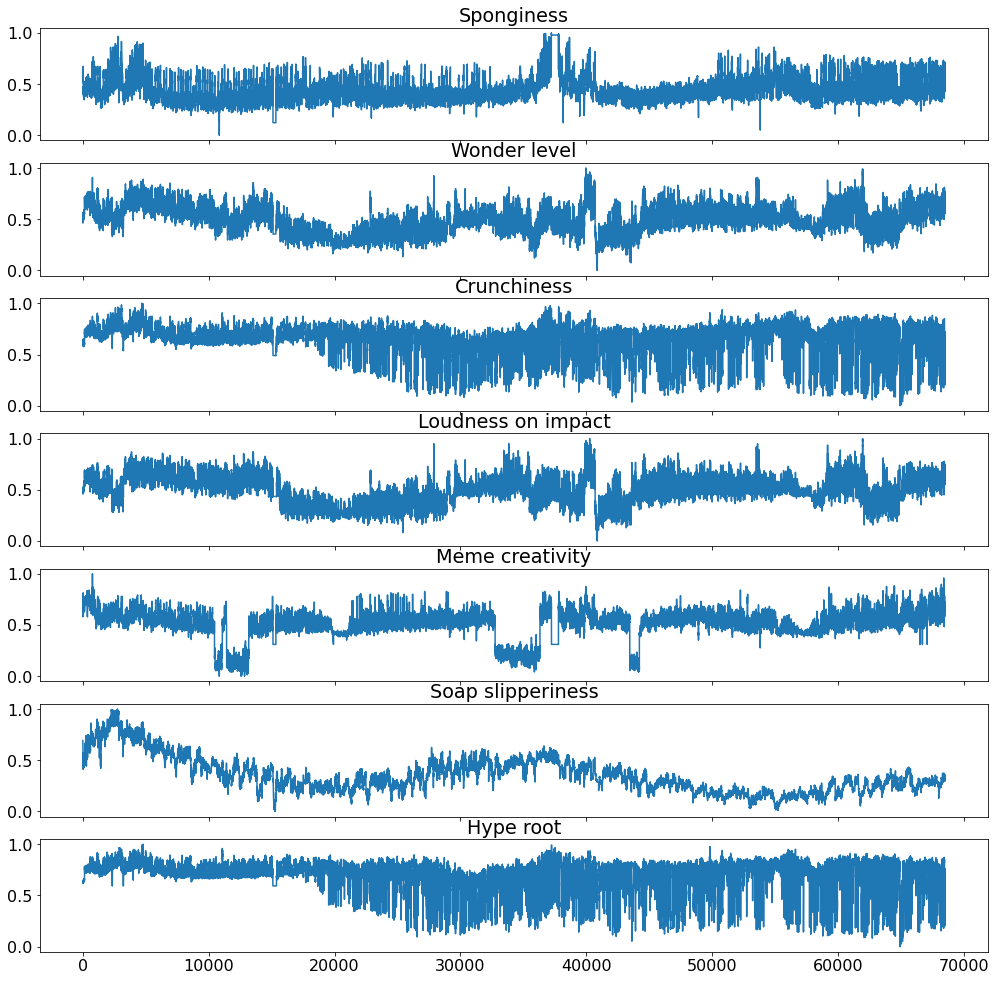

In [7]:
# Data normalization

X_train_raw = dataset
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw - X_min) / (X_max - X_min)

print(X_train_raw.shape)
print(dataset)

# Plot dataset after normalization
inspect_dataframe(X_train_raw, X_train_raw.columns)

In [8]:
window = 100
stride = 5

In [9]:
future = dataset[-window:]
future = (future - X_min) / (X_max - X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 100, 7)

In [10]:
def build_sequences(df, p_target_labels=dataset.columns, p_window=100, p_stride=5, p_telescope=64):
    # Sanity check to avoid runtime errors
    assert p_window % p_stride == 0
    ds = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[p_target_labels].copy().values
    padding_len = len(df) % p_window

    if padding_len != 0:
        # Compute padding length
        padding_len = p_window - len(df) % p_window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')  # Change to float32
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding, temp_label))
        assert len(temp_df) % p_window == 0

    for idx in np.arange(0, len(temp_df) - p_window - p_telescope, p_stride):
        ds.append(temp_df[idx:idx + p_window])
        labels.append(temp_label[idx + p_window:idx + p_window + p_telescope])

    ds = np.array(ds)
    labels = np.array(labels)
    return ds, labels

### Autoregressive Forecasting

In [11]:
target_labels = dataset.columns
telescope = 64

In [12]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
# X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

((13688, 100, 7), (13688, 64, 7))

In [13]:
def inspect_multivariate(X, y, columns, p_telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0, :, i]), len(X_train[0, :, i]) + p_telescope), y[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)
    plt.show()

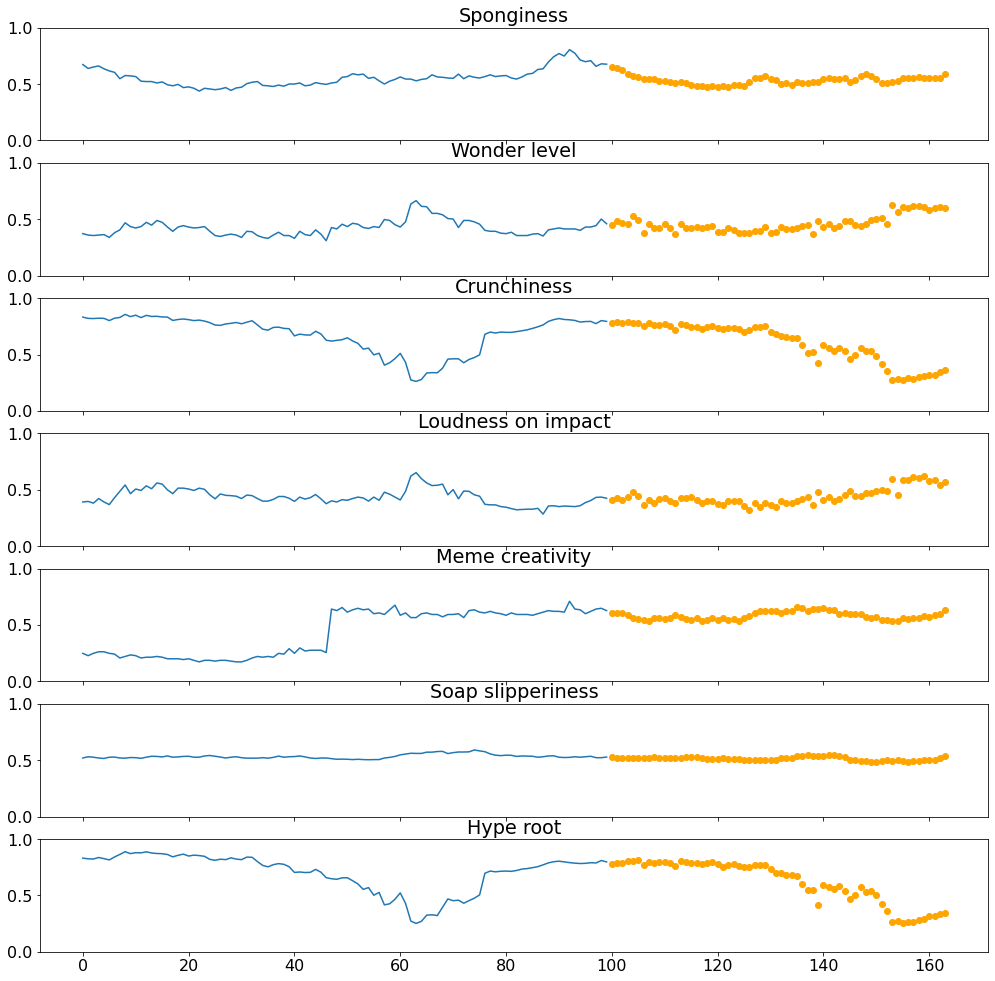

In [14]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [15]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [16]:
import tensorflow.keras.backend as K

class SeqSelfAttention(tfkl.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        super(SeqSelfAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = tfk.initializers.get(kernel_initializer)
        self.bias_initializer = tfk.initializers.get(bias_initializer)
        self.kernel_regularizer = tfk.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tfk.regularizers.get(bias_regularizer)
        self.kernel_constraint = tfk.constraints.get(kernel_constraint)
        self.bias_constraint = tfk.constraints.get(bias_constraint)
        self.attention_activation = tfk.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = K.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': tfk.initializers.serialize(self.kernel_initializer),
            'bias_initializer': tfk.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': tfk.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': tfk.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': tfk.constraints.serialize(self.kernel_constraint),
            'bias_constraint': tfk.constraints.serialize(self.bias_constraint),
            'attention_activation': tfk.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = int(input_shape[2])

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = int(input_shape[2])

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        if self.attention_width is not None:
            if self.history_only:
                lower = K.arange(0, input_len) - (self.attention_width - 1)
            else:
                lower = K.arange(0, input_len) - self.attention_width // 2
            lower = K.expand_dims(lower, axis=-1)
            upper = lower + self.attention_width
            indices = K.expand_dims(K.arange(0, input_len), axis=0)
            e -= 10000.0 * (1.0 - K.cast(lower <= indices, K.floatx()) * K.cast(indices < upper, K.floatx()))
        if mask is not None:
            mask = K.expand_dims(K.cast(mask, K.floatx()), axis=-1)
            e -= 10000.0 * ((1.0 - mask) * (1.0 - K.permute_dimensions(mask, (0, 2, 1))))

        # a_{t} = \text{softmax}(e_t)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        a = e / K.sum(e, axis=-1, keepdims=True)

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q = K.expand_dims(K.dot(inputs, self.Wt), 2)
        k = K.expand_dims(K.dot(inputs, self.Wx), 1)
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e += self.ba[0]
        return e

    def compute_output_shape(self, input_shape):
        output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        indices = K.expand_dims(K.arange(0, input_len), axis=0)
        diagonal = K.expand_dims(K.arange(0, input_len), axis=-1)
        eye = K.cast(K.equal(indices, diagonal), K.floatx())
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - eye)) / batch_size

    @staticmethod
    def get_custom_objects():
        return {'SeqSelfAttention': SeqSelfAttention}

In [17]:
def build_ConvBiLSTM_AR_with_SelfAttention_model(p_input_shape, p_output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=p_input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD,
                       kernel_regularizer=tfk.regularizers.l2(1e-4),
                       bias_regularizer=tfk.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention1')(convlstm)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(att)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(convlstm)
    att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD,
                       kernel_regularizer=tfk.regularizers.l2(1e-4),
                       bias_regularizer=tfk.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention2')(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(att)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(p_output_shape[-1] * p_output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((p_output_shape[-2], p_output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(p_output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    built_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='ConvBiLSTM_AR_with_SelfAttention_model')

    # Compile the model
    built_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return built_model


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Model: "ConvBiLSTM_AR_with_SelfAttention_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 100, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          36864     
_________________________________________________________________
Attention1 (SeqSelfAttention (None, None, 128)         8257      
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
Attention2 (SeqSelfAttention

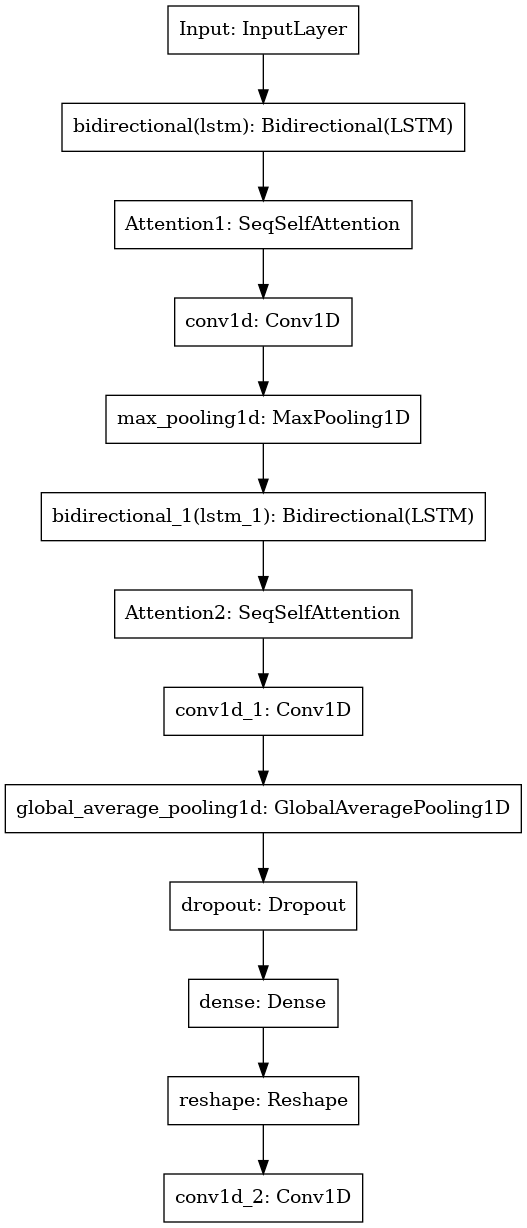

In [18]:
model = build_ConvBiLSTM_AR_with_SelfAttention_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [19]:
# Train the model
callbacks = create_folders_and_callbacks(model_name='ConvBiLSTM_AR_with_SelfAttention_w100_s5_tel64')

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=callbacks
).history

2022-01-02 18:53:32.071942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
193/193 [==============================] - 76s 348ms/step - loss: 0.1269 - root_mean_squared_error: 0.3245 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1300


2022-01-02 18:54:59.013198: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/200
193/193 [==============================] - 64s 333ms/step - loss: 0.0323 - root_mean_squared_error: 0.1303 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1331
Epoch 3/200
193/193 [==============================] - 64s 329ms/step - loss: 0.0309 - root_mean_squared_error: 0.1268 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1319
Epoch 4/200
193/193 [==============================] - 65s 339ms/step - loss: 0.0303 - root_mean_squared_error: 0.1244 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1284
Epoch 5/200
193/193 [==============================] - 65s 337ms/step - loss: 0.0298 - root_mean_squared_error: 0.1224 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1268
Epoch 6/200
193/193 [==============================] - 63s 329ms/step - loss: 0.0293 - root_mean_squared_error: 0.1204 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1265
Epoch 7/200
193/193 [==============================] - 65s 336ms/step - loss: 0.0288 - root_mean_squared_error: 0.1182 -

In [20]:
model.save('ConvBiLSTM_AR_with_SelfAttention_w100_s5_tel64')
# model = tfk.models.load_model('ConvBiLSTM_AR_with_SelfAttention_w100_s5_tel64')

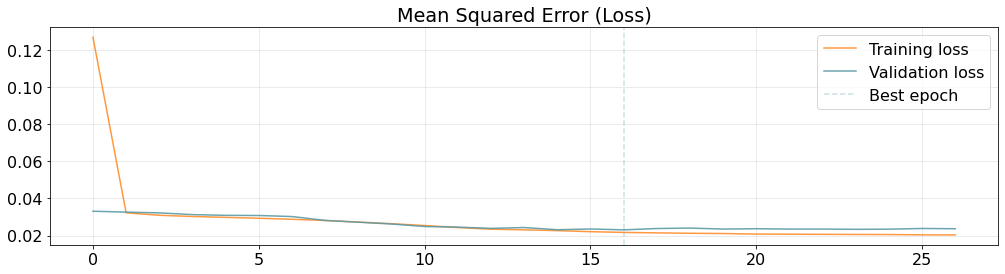

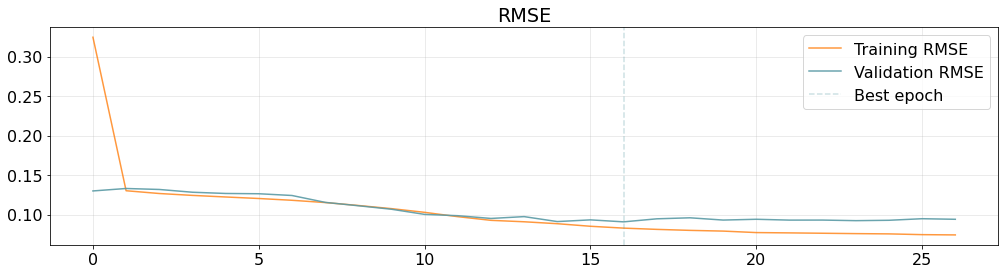

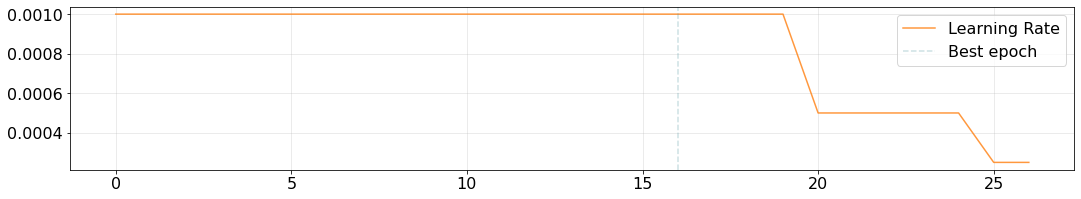

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17, 4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17, 4))
plt.plot(history['root_mean_squared_error'], label='Training RMSE', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation RMSE', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('RMSE')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()